# Alpha Switch Cash

**Instrument:** Cash and Nifty Alpha 50 Index

**Action:** If the momentum slows down, switch to cash. If the momentum picks up, switch to Niifty Alpha 50 Index.

**Why?** Momentum is a factor that has been shown to outperform the market over long periods of time. However, momentum is also known to have large negative deviation. This strategy aims to reduce the downside of the momentum factor by switching to cash when the momentum slows down.

**How to select when to exit?** The strategy uses a 1-month momentum window. We calculate the MOMENTUM_PERCENT_CHANGE as the percentage change in the momentum index over the last 1 month. If MOMENTUM_PERCENT_CHANGE is less than a threshold value called "to_cash", the strategy exits to cash. If the MOMENTUM_PERCENT_CHANGE is higher than "to_momentum" threshold, the strategy enters the momentum index. If the momentum is between "to_cash" and "to_momentum", the strategy stays in whatever is the most recent state i.e. CASH or MOMENTUM.

How to select the thresholds? The thresholds are selected by plotting the MOMENTUM_PERCENT_CHANGE and selecting the values that are most appropriate. The thresholds are selected such that the strategy:

1. Does NOT switch too often.
2. Does NOT stay in cash for too long
3. Does leave Momentum when the momentum is slowing down, even if it is still positive

The thresholds are selected such that the strategy switches to cash when the momentum is slowing down and switches to momentum when the momentum is picking up.

In [137]:
import pandas as pd
import numpy as np
from typing import Optional, List
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

latest_df = pd.read_csv("../data/NIFTY_ALPHA_50_WEEKLY.csv")
latest_df["MOMENTUM_PERCENT_CHANGE"] = latest_df["Close"].pct_change(periods=4) * 100
latest_df["MOMENTUM_PERCENT_CHANGE"] = latest_df["MOMENTUM_PERCENT_CHANGE"].round(2)

In [138]:
latest_df[:-84]

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),MOMENTUM_PERCENT_CHANGE
0,2018-02-08,13037.95,13297.15,13019.30,13264.90,213354255.0,5479.18,NaN
1,2018-02-15,13707.65,13713.55,13432.00,13505.40,158492155.0,5427.42,NaN
2,2018-02-22,13158.75,13210.40,13104.40,13139.20,169922938.0,5190.95,NaN
3,2018-03-01,13300.85,13377.85,13187.85,13202.00,118405778.0,3884.15,NaN
4,2018-03-08,12775.85,12861.05,12509.30,12772.65,240468741.0,5260.59,-3.71
...,...,...,...,...,...,...,...,...
186,2021-11-25,33264.05,33573.60,33011.15,33517.75,184275655.0,9536.06,6.18
187,2021-12-02,32684.20,33206.95,32576.20,33167.35,211144098.0,10903.68,2.50
188,2021-12-09,33751.45,33792.90,33419.10,33757.95,212547809.0,7736.51,1.85
189,2021-12-16,34300.60,34425.25,33853.50,33956.40,175326435.0,7883.53,1.93


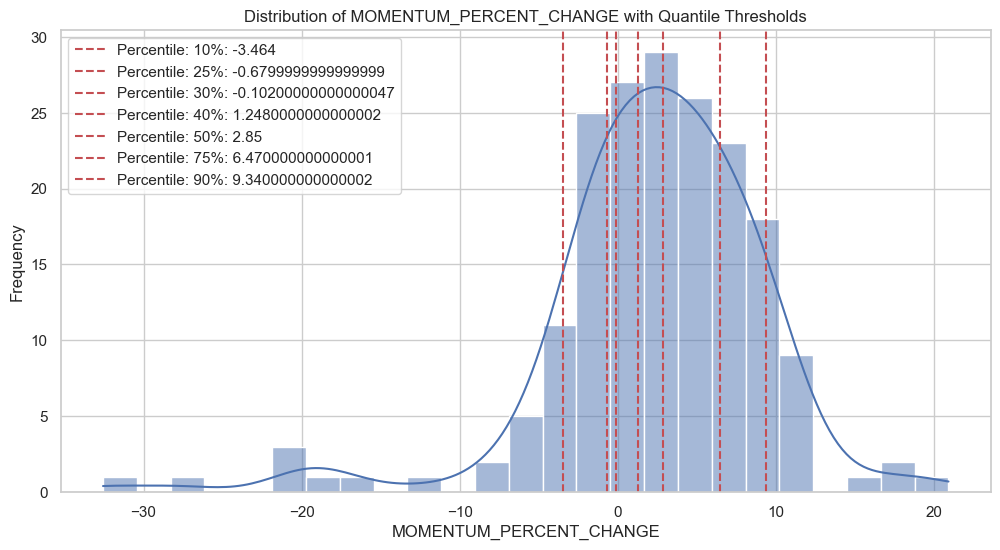

In [139]:
# Filter out NaN values from the MOMENTUM_PERCENT_CHANGE column for plotting
filtered_momentum_percent_change = latest_df["MOMENTUM_PERCENT_CHANGE"].dropna()[:-84]
# Plot the distribution of the MOMENTUM_PERCENT_CHANGE column
quantiles = [0.1, 0.25, 0.3, 0.4, 0.5, 0.75, 0.9]

# Calculate the quantile values from the 'MOMENTUM_PERCENT_CHANGE' column
quantile_values = filtered_momentum_percent_change.quantile(quantiles).tolist()
quantile_map = dict(zip(quantiles, quantile_values))
# Plot the distribution with the quantile thresholds
plt.figure(figsize=(12, 6))
sns.histplot(filtered_momentum_percent_change, bins=25, kde=True)
for idx, q_value in enumerate(quantile_values):
    plt.axvline(
        x=q_value,
        color="r",
        linestyle="--",
        label=f"Percentile: {quantiles[idx]*100:.0f}%: {q_value}",
    )

plt.title("Distribution of MOMENTUM_PERCENT_CHANGE with Quantile Thresholds")
plt.xlabel("MOMENTUM_PERCENT_CHANGE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [140]:
latest_df[latest_df["MOMENTUM_PERCENT_CHANGE"].isna()]

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),MOMENTUM_PERCENT_CHANGE
0,2018-02-08,13037.95,13297.15,13019.30,13264.9,213354255.0,5479.18,NaN
1,2018-02-15,13707.65,13713.55,13432.00,13505.4,158492155.0,5427.42,NaN
2,2018-02-22,13158.75,13210.40,13104.40,13139.2,169922938.0,5190.95,NaN
3,2018-03-01,13300.85,13377.85,13187.85,13202.0,118405778.0,3884.15,NaN


In [141]:
latest_df = latest_df[-84:]
latest_df  # Exclude what was used to find the quantiles

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),MOMENTUM_PERCENT_CHANGE
191,2021-12-30,34119.70,34298.05,33986.40,34183.10,1.436819e+08,8094.49,3.06
192,2022-01-06,34630.20,35015.15,34475.60,34947.25,1.851255e+08,8925.85,3.52
193,2022-01-13,35711.75,36005.00,35581.20,35966.10,2.638287e+08,14046.84,5.92
194,2022-01-20,35526.90,35714.85,35407.95,35675.05,1.850448e+08,11775.49,6.89
195,2022-01-27,33409.25,33409.25,32732.95,32965.80,2.243787e+08,11696.39,-3.56
...,...,...,...,...,...,...,...,...
270,2023-08-10,33891.90,33947.90,33618.45,33721.50,4.555123e+08,7109.93,4.66
271,2023-08-17,33665.20,33857.10,33566.80,33627.55,4.318477e+08,7438.45,1.62
272,2023-08-24,34612.10,34654.25,34195.05,34246.75,3.664924e+08,7991.98,2.75
273,2023-08-31,34589.50,34829.65,34526.05,34723.85,1.134862e+09,22321.97,4.14


In [142]:
def switch(
    latest_df,
    col_name: str = "SWITCH_DYNAMIC",
    initial_value: str = "CASH",
    to_cash: float = -1.96,
    to_momentum: float = 12.0,
) -> pd.DataFrame:
    df = latest_df.copy()
    # Remove any rows where all values are NaN before proceeding
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    switch_list = []
    # Loop through the DataFrame to populate the SWITCH_DYNAMIC column based on the thresholds
    for idx in range(len(df)):
        if idx == 0:
            switch_list.append(initial_value)
            continue
        prev_row = switch_list[idx - 1]
        current_row = df.iloc[idx]
        momentum_change = current_row.get("MOMENTUM_PERCENT_CHANGE")
        if pd.isna(momentum_change):
            switch_value = initial_value
        elif momentum_change < to_cash:
            switch_value = "CASH"
        elif momentum_change > to_momentum:
            switch_value = "MOMENTUM"
        else:
            switch_value = prev_row

        switch_list.append(switch_value)

    df[col_name] = switch_list
    return df


switch_df = switch(
    latest_df=latest_df,
    col_name="SWITCH_DYNAMIC",
    initial_value="CASH",
    to_cash=quantile_map[0.5],
    to_momentum=quantile_map[0.3],
)
switch_df = switch(
    latest_df=switch_df,
    col_name="SWITCH_DYNAMIC_OPTIMISTIC",
    initial_value="CASH",
    to_cash=quantile_map[0.5],
    to_momentum=quantile_map[0.25],
)
switch_df = switch(
    latest_df=switch_df,
    col_name="SWITCH_DYNAMIC_PESSIMISTIC",
    initial_value="CASH",
    to_cash=quantile_map[0.75],
    to_momentum=quantile_map[0.75],
)
switch_df["SWITCH_DYNAMIC"].value_counts(), switch_df[
    "SWITCH_DYNAMIC_OPTIMISTIC"
].value_counts(), switch_df["SWITCH_DYNAMIC_PESSIMISTIC"].value_counts()

(SWITCH_DYNAMIC
 CASH        47
 MOMENTUM    37
 Name: count, dtype: int64,
 SWITCH_DYNAMIC_OPTIMISTIC
 CASH        47
 MOMENTUM    37
 Name: count, dtype: int64,
 SWITCH_DYNAMIC_PESSIMISTIC
 CASH        67
 MOMENTUM    17
 Name: count, dtype: int64)

In [143]:
# Modify the function to use the strategy from the previous month to decide the current month's returns
def add_amount_based_on_strategy(
    df: pd.DataFrame,
    strategy: str,
    initial_amount: float = 1000.0,
    momentum_col: str = "Close",
) -> pd.DataFrame:
    """
    Adds an 'AMOUNT_<STRATEGY>' column to the DataFrame based on the given cash-only strategy.

    Parameters:
        df (pd.DataFrame): The DataFrame to which the new column will be added.
        strategy (str): The strategy column based on which the amount will be calculated.
        initial_amount (float): The initial amount of investment. Default is 1000 INR.
        momentum_col (str): The column representing the momentum TRI. Default is 'NIFTY 200 MOMENTUM 30 TRI'.

    Returns:
        pd.DataFrame: DataFrame with the new 'AMOUNT_<STRATEGY>' column added.
    """
    df_copy = df.copy()
    amount_list = [initial_amount]  # Start with the initial amount
    amount_col = f"AMOUNT_{strategy}"

    for idx in range(1, len(df)):
        prev_row = df_copy.iloc[idx - 1]
        current_row = df_copy.iloc[idx]

        # Use the strategy from the previous month to decide the current month's amount
        if prev_row[strategy] == "MOMENTUM":
            current_amount = amount_list[-1] * (
                current_row[momentum_col] / prev_row[momentum_col]
            )
        else:
            current_amount = amount_list[-1]  # In CASH, just copy the previous value

        amount_list.append(current_amount)

    df_copy[amount_col] = amount_list  # No more slicing, now the lengths should match

    return df_copy


amount_df = add_amount_based_on_strategy(
    switch_df, strategy="SWITCH_DYNAMIC_OPTIMISTIC", initial_amount=1000.0
)
amount_df = add_amount_based_on_strategy(
    amount_df, strategy="SWITCH_DYNAMIC", initial_amount=1000.0
)
amount_df = add_amount_based_on_strategy(
    amount_df, strategy="SWITCH_DYNAMIC_PESSIMISTIC", initial_amount=1000.0
)

# round the values to 2 decimal places
amount_df["AMOUNT_SWITCH_DYNAMIC"] = amount_df["AMOUNT_SWITCH_DYNAMIC"].round(2)
amount_df["AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC"] = amount_df[
    "AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC"
].round(2)
amount_df.tail(24)

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),MOMENTUM_PERCENT_CHANGE,SWITCH_DYNAMIC,SWITCH_DYNAMIC_OPTIMISTIC,SWITCH_DYNAMIC_PESSIMISTIC,AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC,AMOUNT_SWITCH_DYNAMIC,AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC
60,2023-03-09,26917.80,26947.75,26610.25,26661.80,3.393048e+08,7981.81,1.24,CASH,CASH,CASH,986.90,986.90,967.914640
61,2023-03-16,25778.40,25783.30,25300.10,25657.75,4.503408e+08,7888.90,-2.12,CASH,CASH,CASH,986.90,986.90,967.914640
62,2023-03-23,25827.15,26016.85,25763.05,25832.45,2.784254e+08,6474.08,1.65,CASH,CASH,CASH,986.90,986.90,967.914640
63,2023-04-06,25972.90,26169.00,25875.55,26108.85,3.418869e+08,6978.01,0.91,CASH,CASH,CASH,986.90,986.90,967.914640
64,2023-04-20,26919.30,26974.60,26708.15,26743.30,2.945905e+08,4744.13,0.31,CASH,CASH,CASH,986.90,986.90,967.914640
65,2023-04-27,27154.05,27332.10,27150.20,27311.10,2.937939e+08,5478.39,6.44,MOMENTUM,MOMENTUM,CASH,986.90,986.90,967.914640
66,2023-05-04,28088.50,28326.25,28064.05,28300.80,3.951107e+08,8132.46,9.56,MOMENTUM,MOMENTUM,MOMENTUM,1022.67,1022.67,967.914640
67,2023-05-11,28193.85,28251.65,28115.75,28157.85,2.924324e+08,6096.48,7.85,MOMENTUM,MOMENTUM,MOMENTUM,1017.50,1017.50,963.025612
68,2023-05-18,28605.70,28686.30,28199.85,28257.00,3.279849e+08,6709.48,5.66,MOMENTUM,MOMENTUM,CASH,1021.09,1021.09,966.416637
69,2023-05-25,28391.80,28596.15,28376.00,28560.05,3.120497e+08,6912.20,4.57,MOMENTUM,MOMENTUM,CASH,1032.04,1032.04,966.416637


In [144]:
# number of changes from CASH to MOMENTUM and vice versa
def change_count(amount_df, strategy: str = "SWITCH_DYNAMIC"):
    df = amount_df.copy()
    df["CHANGE"] = df[strategy].shift(1) != df[strategy]
    df["CHANGE"] = df["CHANGE"].astype(int)
    return df["CHANGE"].sum()


# Number of changes from CASH to MOMENTUM
def sell_count(amount_df, strategy: str = "SWITCH_DYNAMIC"):
    df = amount_df.copy()
    df["CHANGE"] = df[strategy].shift(1) != df[strategy]
    df["CHANGE"] = df["CHANGE"].astype(int)
    df["SELL"] = df["CHANGE"] * (df[strategy] == "CASH")
    return df["SELL"].sum()


pd.DataFrame(
    {
        "Strategy": [
            "SWITCH_DYNAMIC",
            "SWITCH_DYNAMIC_OPTIMISTIC",
            "SWITCH_DYNAMIC_PESSIMISTIC",
        ],
        "Change Count": [
            change_count(amount_df, strategy="SWITCH_DYNAMIC"),
            change_count(amount_df, strategy="SWITCH_DYNAMIC_OPTIMISTIC"),
            change_count(amount_df, strategy="SWITCH_DYNAMIC_PESSIMISTIC"),
        ],
        "Sell Count": [
            sell_count(amount_df, strategy="SWITCH_DYNAMIC"),
            sell_count(amount_df, strategy="SWITCH_DYNAMIC_OPTIMISTIC"),
            sell_count(amount_df, strategy="SWITCH_DYNAMIC_PESSIMISTIC"),
        ],
    }
)

,Strategy,Change Count,Sell Count
0,SWITCH_DYNAMIC,14,7
1,SWITCH_DYNAMIC_OPTIMISTIC,14,7
2,SWITCH_DYNAMIC_PESSIMISTIC,15,8


In [145]:
amount_df.tail(24)[["Date", "Close", "SWITCH_DYNAMIC", "AMOUNT_SWITCH_DYNAMIC", "SWITCH_DYNAMIC_OPTIMISTIC", "AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC", "SWITCH_DYNAMIC_PESSIMISTIC", "AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC"]]

,Date,Close,SWITCH_DYNAMIC,AMOUNT_SWITCH_DYNAMIC,SWITCH_DYNAMIC_OPTIMISTIC,AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC,SWITCH_DYNAMIC_PESSIMISTIC,AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC
60,2023-03-09,26661.80,CASH,986.90,CASH,986.90,CASH,967.914640
61,2023-03-16,25657.75,CASH,986.90,CASH,986.90,CASH,967.914640
62,2023-03-23,25832.45,CASH,986.90,CASH,986.90,CASH,967.914640
63,2023-04-06,26108.85,CASH,986.90,CASH,986.90,CASH,967.914640
64,2023-04-20,26743.30,CASH,986.90,CASH,986.90,CASH,967.914640
65,2023-04-27,27311.10,MOMENTUM,986.90,MOMENTUM,986.90,CASH,967.914640
66,2023-05-04,28300.80,MOMENTUM,1022.67,MOMENTUM,1022.67,MOMENTUM,967.914640
67,2023-05-11,28157.85,MOMENTUM,1017.50,MOMENTUM,1017.50,MOMENTUM,963.025612
68,2023-05-18,28257.00,MOMENTUM,1021.09,MOMENTUM,1021.09,CASH,966.416637
69,2023-05-25,28560.05,MOMENTUM,1032.04,MOMENTUM,1032.04,CASH,966.416637


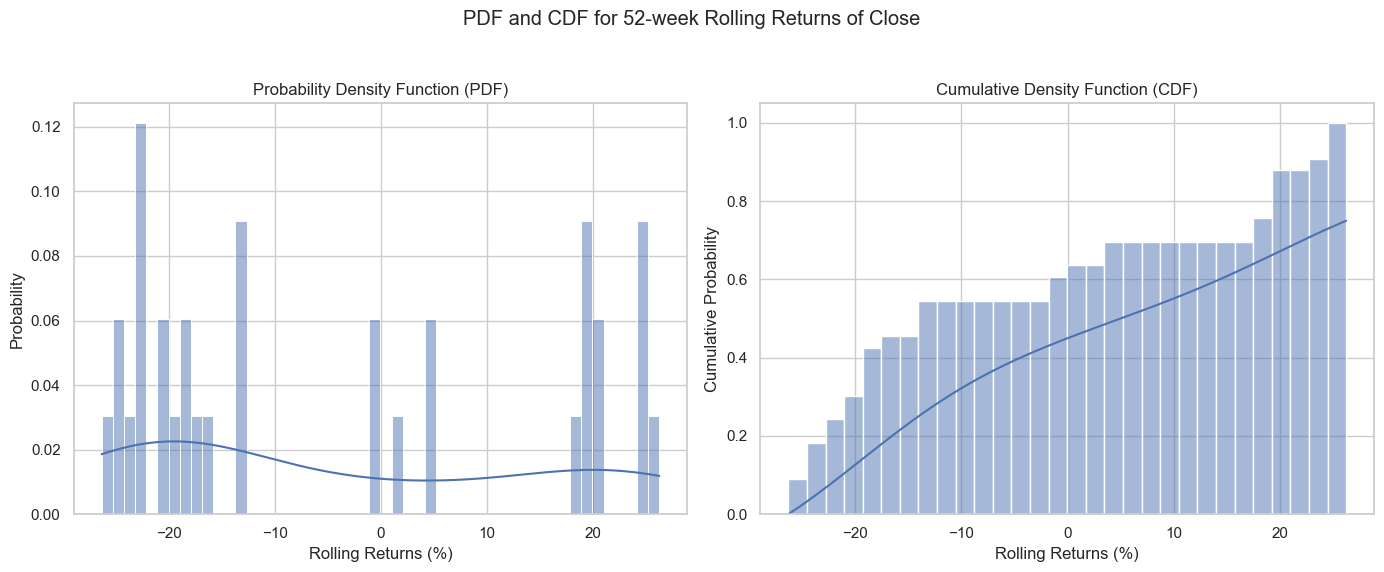

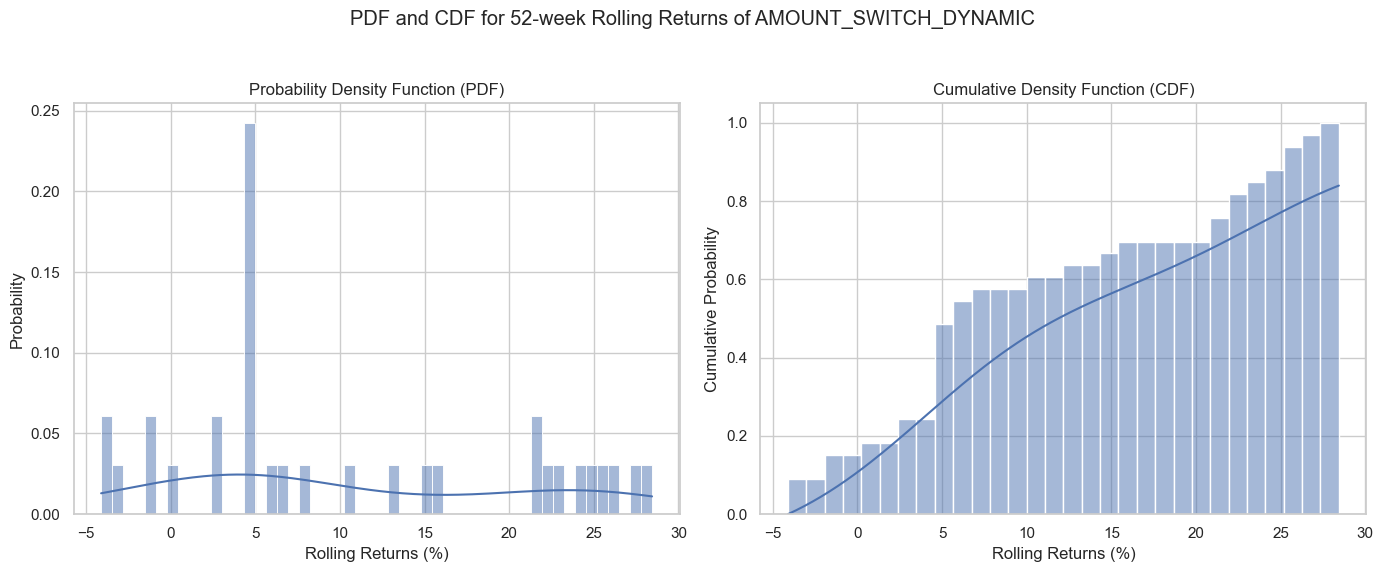

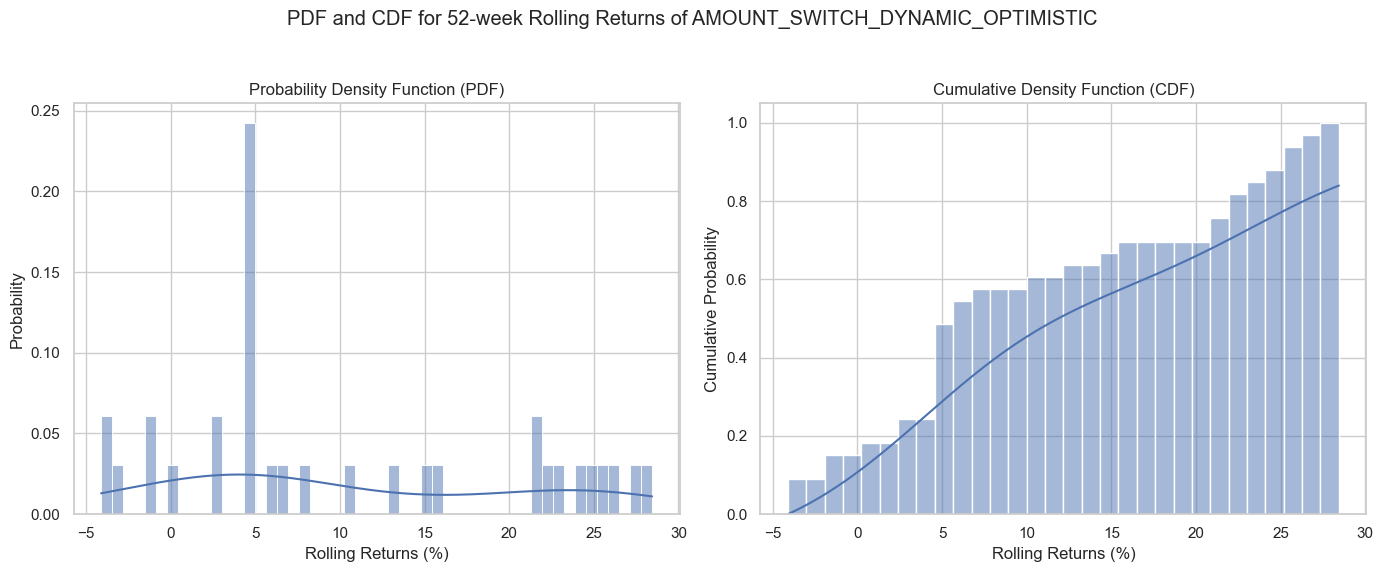

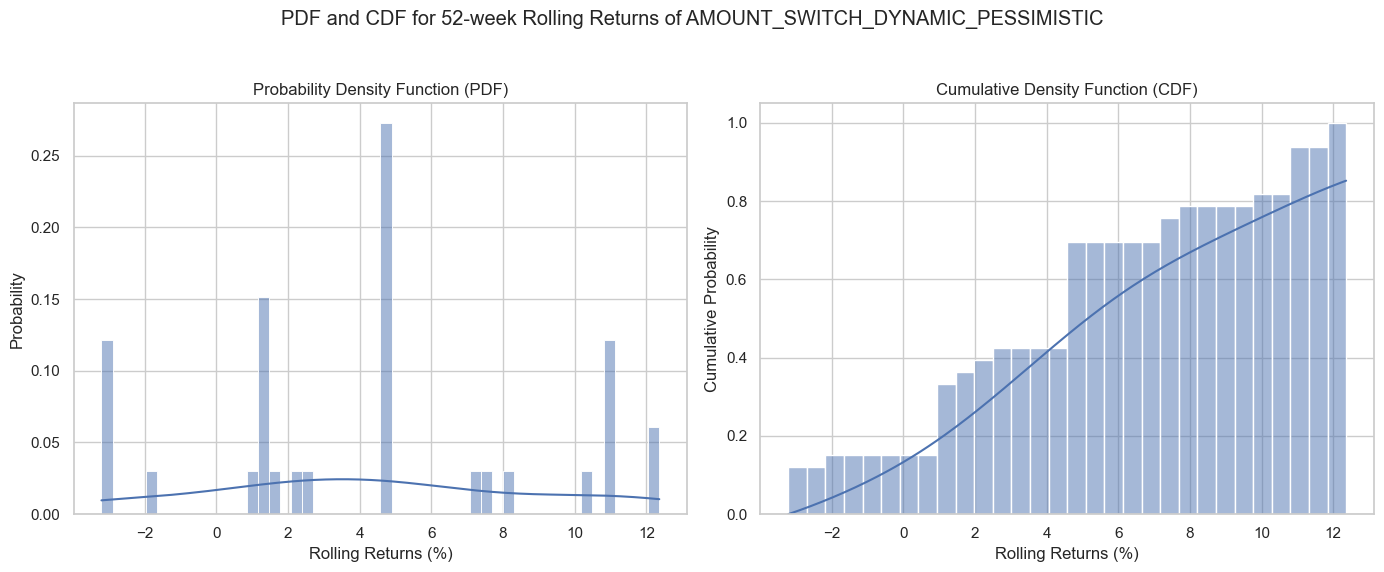

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate rolling returns for weekly data
def calculate_rolling_returns_weekly(df: pd.DataFrame, col_name: str, weeks: int) -> pd.Series:
    start_values = df[col_name].shift(weeks - 1)
    end_values = df[col_name]
    cagr = ((end_values / start_values) ** (1 / (weeks / 52))) - 1
    return cagr * 100  # convert to percentage

# Function to plot PDF and CDF for weekly data
def plot_pdf_cdf(df: pd.DataFrame, col_name: str, weeks: int):
    rolling_returns = calculate_rolling_returns_weekly(df, col_name, weeks).dropna()
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plt.suptitle(f"PDF and CDF for {weeks}-week Rolling Returns of {col_name}")
    sns.histplot(rolling_returns, bins=50, kde=True, stat="probability", ax=axes[0])
    axes[0].set_title("Probability Density Function (PDF)")
    axes[0].set_xlabel("Rolling Returns (%)")
    axes[0].set_ylabel("Probability")
    sns.histplot(
        rolling_returns,
        bins=30,
        kde=True,
        cumulative=True,
        stat="probability",
        ax=axes[1],
    )
    axes[1].set_title("Cumulative Density Function (CDF)")
    axes[1].set_xlabel("Rolling Returns (%)")
    axes[1].set_ylabel("Cumulative Probability")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_pdf_cdf(amount_df, "Close", 52)
plot_pdf_cdf(amount_df, "AMOUNT_SWITCH_DYNAMIC", 52)
plot_pdf_cdf(amount_df, "AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC", 52)
plot_pdf_cdf(amount_df, "AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC", 52)

In [147]:
from typing import List
import numpy as np

# 📉: Modify the existing functions to work with weekly data rather than monthly.

# Helper function to calculate CAGR for weekly data
def cagr_weekly(end_value, start_value, periods):
    return (end_value / start_value) ** (1 / (periods / 52)) - 1

# Function to calculate common backtest statistics for weekly data
def backtest_stats(df: pd.DataFrame, columns: List[str], rf_rate: float = 0.07) -> pd.DataFrame:
    stats = {}
    for col in columns:
        col_stats = {}
        
        # Calculate CAGR for weekly data
        cagr_value = cagr_weekly(df[col].iloc[-1], df[col].iloc[0], len(df))
        col_stats["CAGR"] = cagr_value

        # Calculate annualized risk for weekly data
        df["returns"] = df[col].pct_change().dropna()
        annual_risk = df["returns"].std() * np.sqrt(52)
        col_stats["Annualized Risk"] = annual_risk

        # Sharpe Ratio
        sharpe_ratio = (cagr_value - rf_rate) / annual_risk
        col_stats["Sharpe Ratio"] = sharpe_ratio

        # Max Drawdown
        df["cum_return"] = (1 + df["returns"]).cumprod()
        df["cum_roll_max"] = df["cum_return"].cummax()
        df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
        df["drawdown_pct"] = df["drawdown"] / df["cum_roll_max"]
        max_drawdown = df["drawdown_pct"].max()
        col_stats["Max Drawdown"] = max_drawdown

        # Sortino Ratio
        df["downside_returns"] = 0
        target = 0
        mask = df["returns"] < target
        df.loc[mask, "downside_returns"] = df["returns"]**2
        expected_return = df["returns"].mean()
        downside_std = np.sqrt(df["downside_returns"].mean())
        sortino_ratio = (expected_return - rf_rate) / downside_std
        col_stats["Sortino Ratio"] = sortino_ratio

        # Calmar Ratio
        calmar_ratio = cagr_value / max_drawdown
        col_stats["Calmar Ratio"] = calmar_ratio

        stats[col] = col_stats

    return pd.DataFrame(stats)

# Code ends here, and it's now prepared to handle weekly data.
backtest_stats(
    amount_df,
    columns=[
        "Close",
        "AMOUNT_SWITCH_DYNAMIC",
        "AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC",
        "AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC",
    ],
)

,Close,AMOUNT_SWITCH_DYNAMIC,AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC,AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC
CAGR,0.029734,0.150525,0.150525,0.035382
Annualized Risk,0.256216,0.135955,0.135955,0.096790
Sharpe Ratio,-0.157156,0.592288,0.592288,-0.357665
Max Drawdown,0.314251,0.083418,0.083418,0.075942
Sortino Ratio,-2.473514,-5.262964,-5.262964,-7.219854
Calmar Ratio,0.094619,1.804453,1.804453,0.465902
